In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
# Defines the net in a class. The 'forward' call defines the operations in order
# Simple arch:
# - two conv layers (ReLU activation)
# - Max pool
# - Dropout
# - Fully connected (ReLU)
# - Dropout
# - Fully connected (Softmax)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # Transforms to probabliites of labels
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
# Define a transfrom to convert and normalize the image. The values are the mean and std of MNIST
# See: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457 
transform = transform=transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
# Using torchvision.datasets, we can dowbload a variety of Datasets
# Note that the datasets will not be re-downloaded if they exist
# See: https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
dataset_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset_test = datasets.MNIST('../data', train=False, download=True, transform=transform)

In [5]:
len(dataset_train)

60000

In [6]:
len(dataset_test)

10000

Pytorch provides a powerful class called a `DataLoader`. This class provides methods for effeciently iterating through data. And allows for data to be fetched per-batch, so that you don't need to load it all into memory at once. For a small dataset like MNIST, this is not necessary, but as the datasets grow, this can be incredibly useful. Thus, it is valuable to learn how they work and how to use them.

In [9]:
# Some hyperparams
# How often to log info
log_interval = 100
batch_size = 64
epochs = 5

# Various options for the loader.
# Note: For GPUs, num_workers is recommended to be set to 1, and instead use `pin_memory`.
# This is because of nuances of CUDA and multithreading.
# See: https://pytorch.org/docs/stable/data.html#multi-process-data-loading
loader_options = {
    'batch_size': batch_size,
    'num_workers': 1,
    'pin_memory': True,
    'shuffle': True
}
train_loader = torch.utils.data.DataLoader(dataset_train, **loader_options)
test_loader = torch.utils.data.DataLoader(dataset_test, **loader_options)

model = Net().cuda()
# Puts the model into 'Train' mode (enables, dropoout, changes BN behavior, etc.)
# See: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
model.train()
# Setup the optimizer, using Adadelta and a learning rate of 1
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

train_losses = []
test_losses = []
for epoch in range(1, 5):
    # Puts the model into 'Train' mode (enables, dropoout, changes BN behavior, etc.)
    # See: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    model.train()
    # loop through the train loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get data and put on GPU
        data, target = data.cuda(), target.cuda()
        # Reset optimizer
        optimizer.zero_grad()
        # Run a forward pass
        output = model(data)
        # Negative log likelihood
        loss = F.nll_loss(output, target)
        # Back-propogate
        loss.backward()
        # Step the optimizer
        optimizer.step()

        train_losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    print('-'*20)
    # Run evaluation each epoch
    # Puts model in evaluation mode (opposite of train mode)
    model.eval()
    test_loss = 0
    correct = 0
    # Tells PyTorch that there is no gradient, since we are testing
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()
            # Forward pass
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Sum the number of correct labels
            # `view_as` reshapes the target to match `pred`
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Get loss per sample
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))
    print('-'*20)

    test_losses.append(test_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296918
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.257840
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.233692
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.085598
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.255528
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.166891
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.067517
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.070393
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.115076
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.045190
--------------------

Test set: Average loss: 0.0575, Accuracy: 9823/10000 (98%)

--------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.094124
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.049489
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.104745
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.104818
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.179039
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.091737
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.004074
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.230168
Train Epo

In [90]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25

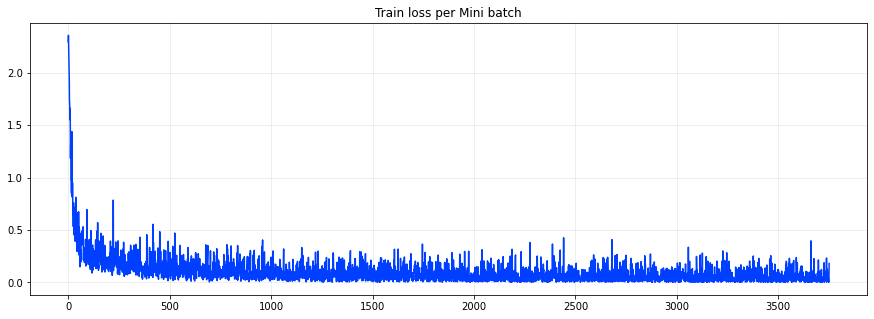

In [95]:
plt.plot(train_losses)
_ = plt.title('Train loss per Mini batch')


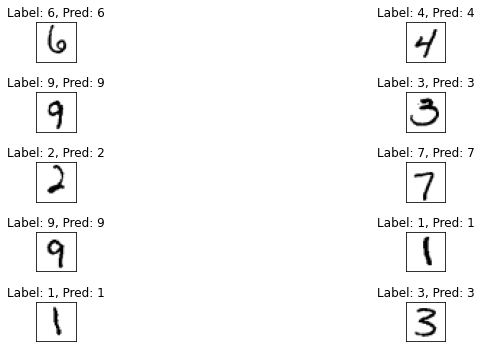

In [94]:
model.eval()
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(10):
    rand_index = np.random.randint(0, len(dataset_test))
    rand_img = dataset_test[rand_index][0]
    gt_label = dataset_test[rand_index][1]

    preds = model(rand_img.view(1, 1, 28, 28).cuda())
    pred_label = preds.argmax().cpu().numpy()

    axs[i].imshow(rand_img.numpy()[0], cmap='binary')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title('Label: %s, Pred: %s'%(gt_label, pred_label))
plt.tight_layout()
plt.show()